In [1]:
# http://qiita.com/tsunaki/items/a5f3f975a31dc45fc9c9
"""
#  TensorFlow(LSTM)で株価予想 〜 株予想その１ 〜
スクレイピングで持ってくる前にダウンロードして実験できるサイトから実験。
  http://k-db.com/

今回の対象は「日経平均」の2007年〜2017年の情報。
日付, 始値, 高値, 安値, 終値のデータあり
今回使用するデータは終値を利用。

アプローチ
　　株については過去の実績を統計的に分析するより、時系列を
  用いたRNN(Recurrent Neural Network)(※2)で予測するほうが向いていると
  考えられるので、RNNの拡張であるLSTM(Long short-term memory)を使ってみる。
"""
pass

In [2]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM

class Prediction :

  def __init__(self):
    self.length_of_sequences = 10
    self.in_out_neurons = 1
    self.hidden_neurons = 300

  def create_model(self) :
    model = Sequential()
    model.add(LSTM(self.hidden_neurons, \
              batch_input_shape=(None, self.length_of_sequences, self.in_out_neurons), \
              return_sequences=False))
    model.add(Dense(self.in_out_neurons))
    model.add(Activation("linear"))
    model.compile(loss="mape", optimizer="adam")
    return model


  def train(self, X_train, y_train) :
    model = self.create_model()
    # 学習
    model.fit(X_train, y_train, batch_size=10, epochs=100)
    return model

class Test :
    def __init__(self):
        self.length_of_sequences = 10

    def load_data(self):
        data = None
        for year in range(2011, 2017):
            path = '/usr/local/zeppelin/work/anom/indices_I101_1d_' + str(year) +  '.csv'
            print("read path:", path)
            data_ = pd.read_csv(path, encoding="SHIFT-JIS")
            data = data_ if (data is None) else pd.concat([data, data_])

        return data

    def load_data2(self, data, n_prev=10):
        X, Y = [], []
        for i in range(len(data) - n_prev):
            X.append(data.iloc[i:(i+n_prev)].as_matrix())
            Y.append(data.iloc[i+n_prev].as_matrix())
        retX = numpy.array(X)
        retY = numpy.array(Y)
        return retX, retY

    def map_data(self, data):
        data.columns = ['date', 'open', 'high', 'low', 'close']
        data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
        # 終値のデータを標準化
        data['close'] = preprocessing.scale(data['close'])
        data = data.sort_values(by='date')
        data = data.reset_index(drop=True)
        data = data.loc[:, ['date', 'close']]
        return data
    
    def split_data(self, data):
        # 2割をテストデータへ
        split_pos = int(len(data) * 0.8)
        x_train, y_train = self.load_data2(data[['close']].iloc[0:split_pos], self.length_of_sequences)
        x_test,  y_test  = self.load_data2(data[['close']].iloc[split_pos:], self.length_of_sequences)
        return x_train, y_train, x_test,  y_test 

    def execute(self):
        prediction = Prediction()

        ## データ準備
        # データファイルの読み込み
        data = self.load_data()
        # 必要データの絞り込み
        data = self.map_data(data)
        # 訓練データと試験データの分割
        x_train, y_train, x_test,  y_test  = self.split_data(data)

        model = prediction.train(x_train, y_train)

        predicted = model.predict(x_test)
        result = pd.DataFrame(predicted)
        result.columns = ['predict']
        result['actual'] = y_test
        result.plot()
        plt.show()


Using TensorFlow backend.


read path: /usr/local/zeppelin/work/anom/indices_I101_1d_2011.csv
read path: /usr/local/zeppelin/work/anom/indices_I101_1d_2012.csv
read path: /usr/local/zeppelin/work/anom/indices_I101_1d_2013.csv
read path: /usr/local/zeppelin/work/anom/indices_I101_1d_2014.csv
read path: /usr/local/zeppelin/work/anom/indices_I101_1d_2015.csv
read path: /usr/local/zeppelin/work/anom/indices_I101_1d_2016.csv
Epoch 1/100
1166/1166 [==============================] - 4s - loss: 46.3872     
Epoch 2/100
1166/1166 [==============================] - 3s - loss: 30.2830     
Epoch 3/100
1166/1166 [==============================] - 3s - loss: 25.2253     
Epoch 4/100
1166/1166 [==============================] - 3s - loss: 23.4787     
Epoch 5/100
1166/1166 [==============================] - 3s - loss: 20.7550     
Epoch 6/100
1166/1166 [==============================] - 3s - loss: 19.8575     
Epoch 7/100
1166/1166 [==============================] - 3s - loss: 19.9391     
Epoch 8/100
1166/1166 [==============

1166/1166 [==============================] - 3s - loss: 14.8197     
Epoch 97/100
1166/1166 [==============================] - 3s - loss: 15.6906     
Epoch 98/100
1166/1166 [==============================] - 3s - loss: 15.2646     
Epoch 99/100
1166/1166 [==============================] - 3s - loss: 15.8882     
Epoch 100/100
1166/1166 [==============================] - 3s - loss: 14.7629     


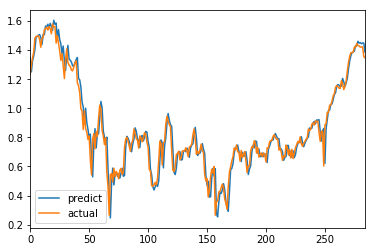

In [3]:
test = Test()
test.execute()